In [1]:
!pip install --upgrade pandas seaborn google-cloud-aiplatform tdqm google-generativeai tiktoken
!gcloud auth application-default login

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 25.1 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.7/150.7 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 677.8/677.8 kB 33.8 MB/s eta 0:00:00
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.2
    Uninstalling google-ai-generativelanguage-0.6.2:
      Successfully uninstalled google-ai-generativelanguage-0.6.2
  Attempting uninstall: google-generativeai
    Found existing installation: google-generativeai 0.5.2
    Uninstalling google-generativeai-0.5.2:
      Successfully uninstalled google-generativeai-0.5.2
  Attempting uninstall: google-cloud-aiplatform
    Found existing installation: google-cloud-aiplatform 1.50.0
    Uninstalling google-cloud-aiplatform-1.50.0:
      Successfully uninstalled google-cloud-aiplatform-1.50.0
Your browser has been opened to visit:

    https://accounts.google.com/o/

In [2]:
import pandas as pd
import glob
import csv
import re
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
import google.generativeai as genai
import os
import time
from tqdm import tqdm
import base64
import vertexai
from vertexai.generative_models import GenerativeModel, Part, FinishReason
import vertexai.preview.generative_models as generative_models
from google.api_core.exceptions import InternalServerError, ResourceExhausted
import json
from tqdm.auto import tqdm
import re
import tiktoken
tqdm.pandas()

In [3]:
vertexai.init(project="yolo-410704", location="us-central1")
gemini_pro_long = GenerativeModel("gemini-1.5-pro-preview-0409")
gemini_pro = GenerativeModel("gemini-pro")

In [4]:
dfs = []

def read_file(file):
    try:
        return open(directory + file + ".txt", "r").read()
    except:
        return None

for info_file in glob.glob("RusLit/**/info.csv", recursive=True):
    try:
        directory = info_file[:-8]
        info = pd.read_csv(info_file)
        info["author"] = directory.split("/")[2]
        info["type"] = directory.split("/")[1]
        info["text"] = info["name"].map(read_file)
        dfs.append(info)
    except:
        pass

df = pd.concat(dfs, ignore_index=True).dropna()
df["year"] = (
    df["year"].astype(str).map(lambda x: x.split("-")[0].split(".")[0]).astype(int)
)
df = df.dropna()

In [11]:
enc = tiktoken.encoding_for_model("gpt-4o")

df_chekhov = df[df["author"] == "Chekhov"].copy()
df_chekhov["tokens"] = df_chekhov["text"].apply(lambda text: len(enc.encode(text)))
df_chekhov = df_chekhov[df_chekhov["tokens"] < 60000]

with open('chekhov.json', 'w') as file:
    json.dump(df_chekhov.set_index('name')['text'].to_dict(), file)

In [41]:
retry_limit = 5


def get_genres(text, name):
    try:
        for attempt in range(retry_limit):
            try:
                return (
                    gemini_pro_long.generate_content(
                        text
                        + "Please provide a comma-separated list of single-word genres that best describe the text above: "
                    )
                    .candidates[0]
                    .content.parts[0]
                    .text
                )
            except ResourceExhausted:
                time.sleep(60)
    except InternalServerError:
        print(f"InternalServerError on {name} text")
    except IndexError:
        print(f"IndexError on {name} text")
    for attempt in range(retry_limit):
        try:
            return (
                gemini_pro_long.generate_content(
                    name
                    + "Please provide a comma-separated list of single-word genres that best describe the text above: "
                )
                .candidates[0]
                .content.parts[0]
                .text
            )
        except ResourceExhausted:
            time.sleep(60)
    print(f"failed on {name}")
    return None


try:
    df = pd.read_csv("gemini.csv")
except:
    df["genres"] = [
        get_genres(text, title)
        for text, title in tqdm(zip(df["text"], df["name"]), desc="Generating genres")
    ]
    df.to_csv("gemini.csv", index=False)

In [88]:
df = df.dropna()
df["genres_list"] = df["genres"].map(lambda x: x.strip().lower().split(", "))

In [94]:
df

,name,year,author,type,genres,genres_list
0,Соловьиный сад,1915,Blok,poems,"Poem, Lyric, Symbolism \n","[poem, lyric, symbolism]"
1,Двенадцать,1918,Blok,poems,"poem, epic, modernist, symbolist \n","[poem, epic, modernist, symbolist]"
2,Скифы,1918,Blok,poems,"History, Anthropology \n","[history, anthropology]"
3,Возмездие,1921,Blok,poems,"Poem, Epic, Tragedy, History, Philosophy \n","[poem, epic, tragedy, history, philosophy]"
4,19 октября,1825,Pushkin,poems,"Elegy, Ode, Lyric, Romantic, Poetry \n","[elegy, ode, lyric, romantic, poetry]"
...,...,...,...,...,...,...
324,Капитанская дочка,1833,Pushkin,prose,"Historical, Fiction, Romance \n","[historical, fiction, romance]"
325,Кирджали,1834,Pushkin,prose,"Fiction, Historical, Adventure \n","[fiction, historical, adventure]"
326,Пиковая дама,1833,Pushkin,prose,"Fiction, Novella, Gothic, Horror \n","[fiction, novella, gothic, horror]"
327,Повести Белкина,1830,Pushkin,prose,"Fiction, Short stories, Novella \n","[fiction, short stories, novella]"


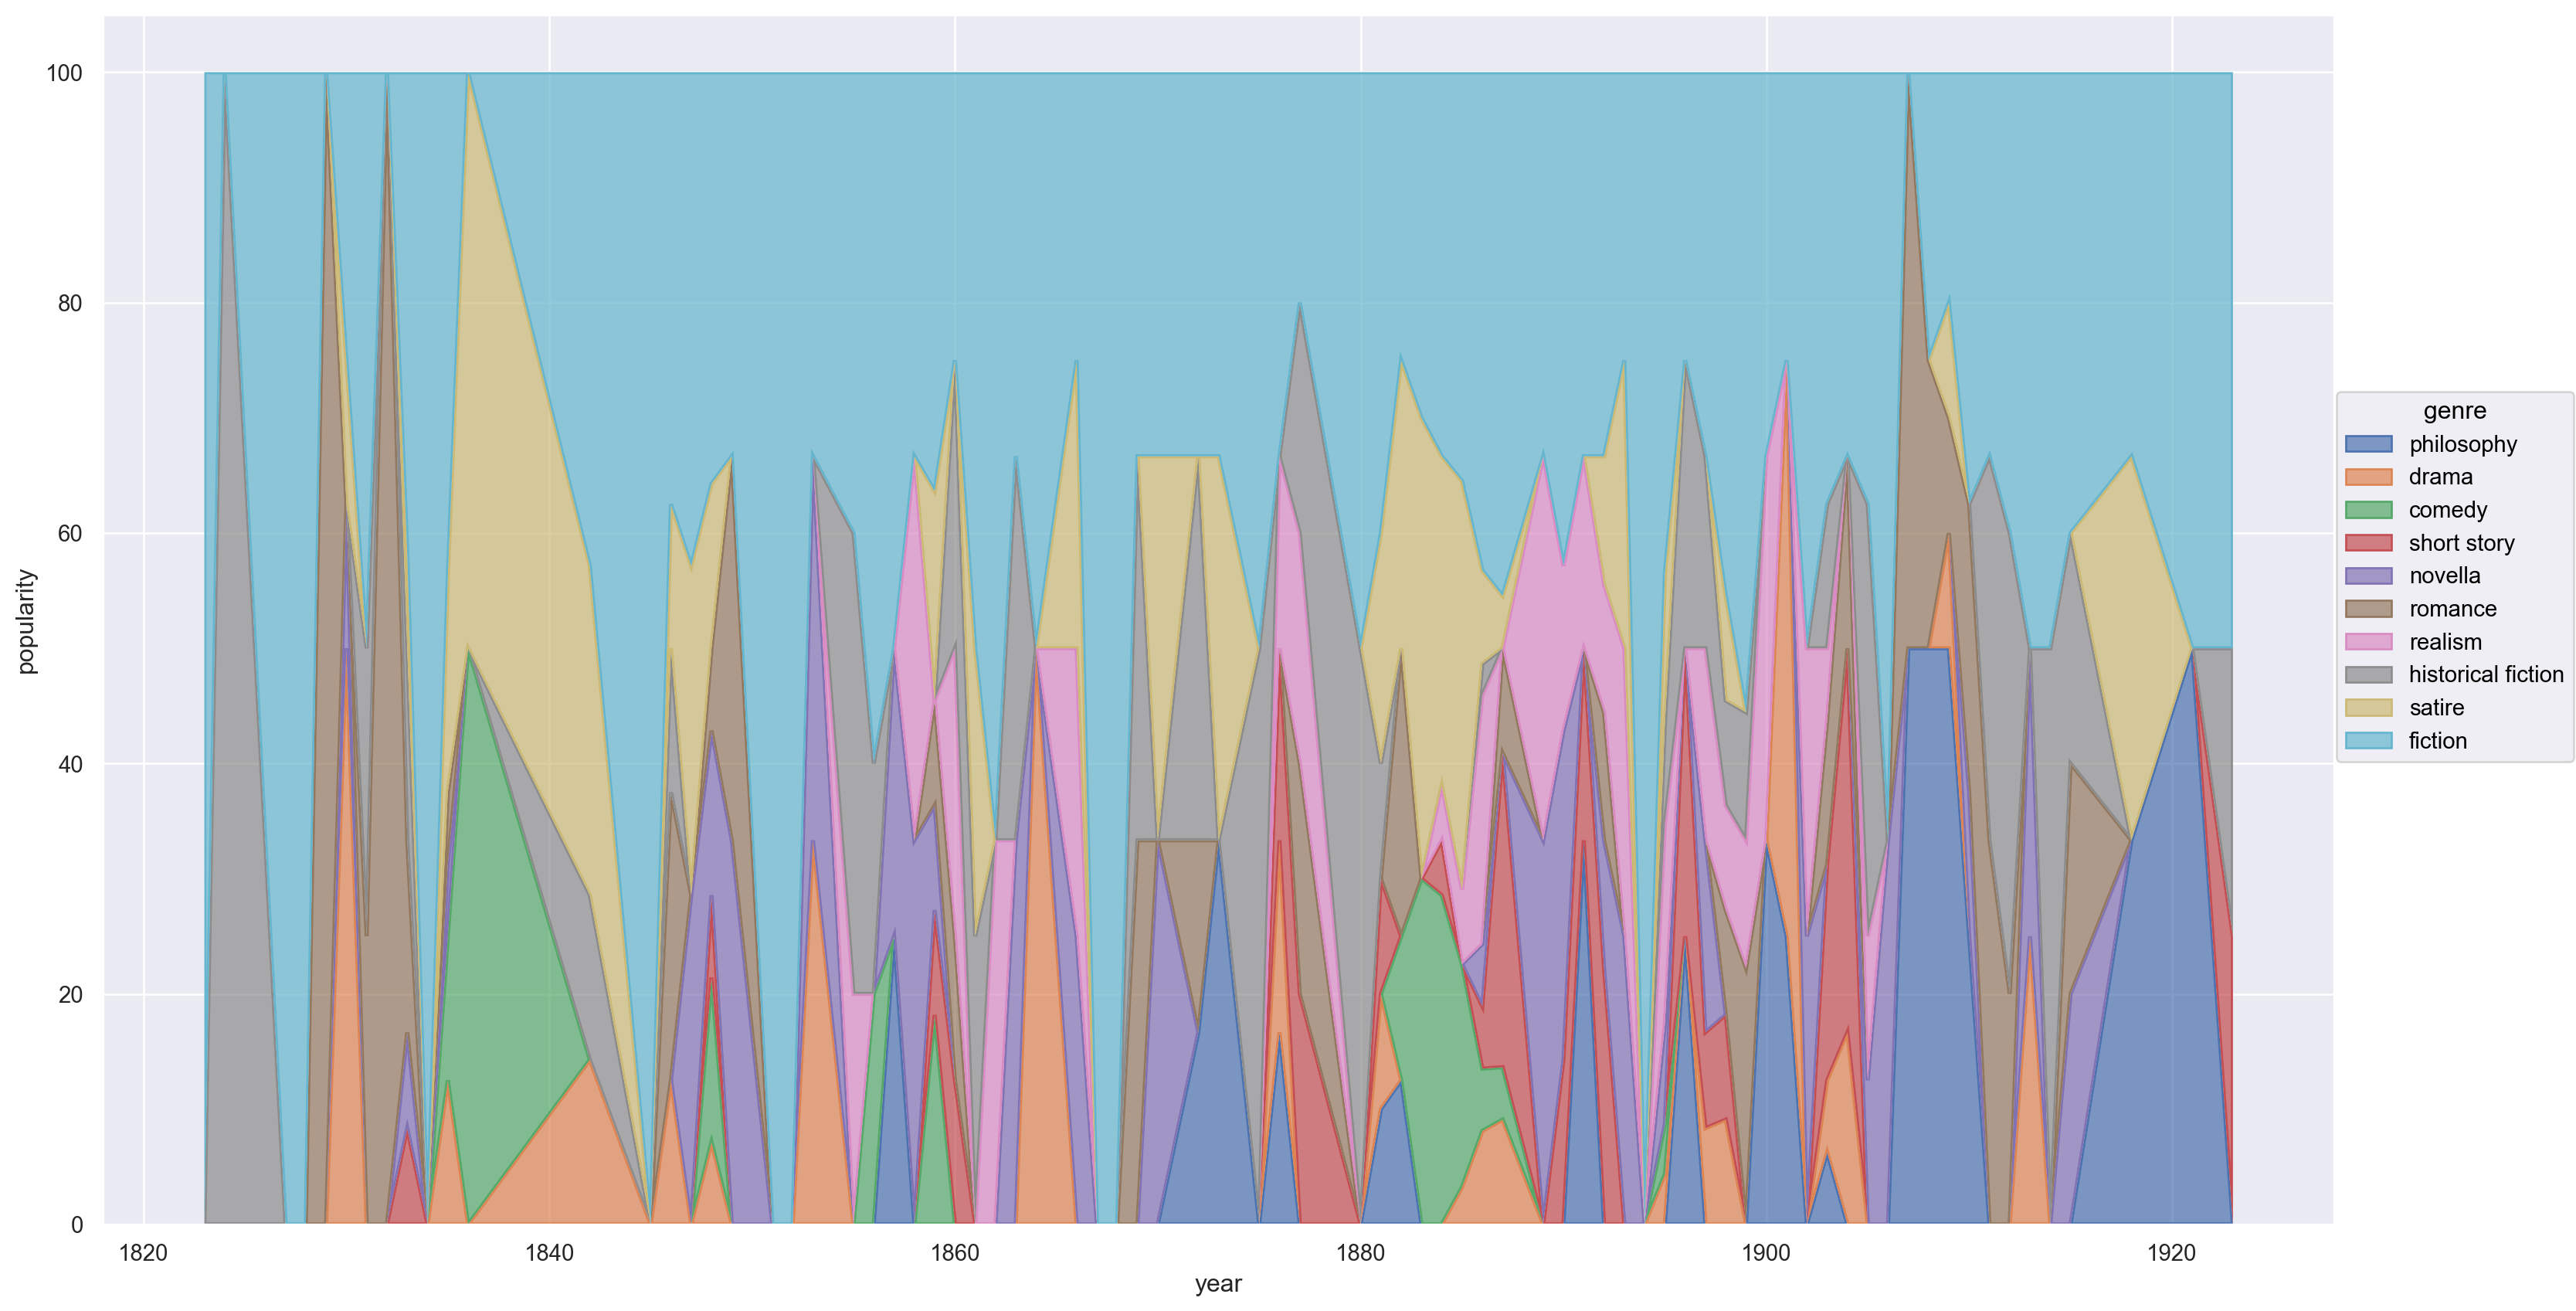

In [89]:
genre_trends = df.explode("genres_list").groupby(["year", "genres_list"]).size().unstack(fill_value=0)
filtered_genre_trends = genre_trends[genre_trends.sum().sort_values().index[-10:]]
percentage_filtered_genre_trends = (
    filtered_genre_trends.divide(filtered_genre_trends.sum(axis=1), axis=0) * 100
).reset_index()
melted_percentage_filtered_genre_trends = percentage_filtered_genre_trends.melt(
    id_vars="year", var_name="genre", value_name="popularity"
)

so.Plot(
    melted_percentage_filtered_genre_trends, "year", "popularity", color="genre"
).add(so.Area(alpha=0.7), so.Stack()).layout(size=(16, 9)).save(
    "gemini1.png", bbox_inches="tight"
)

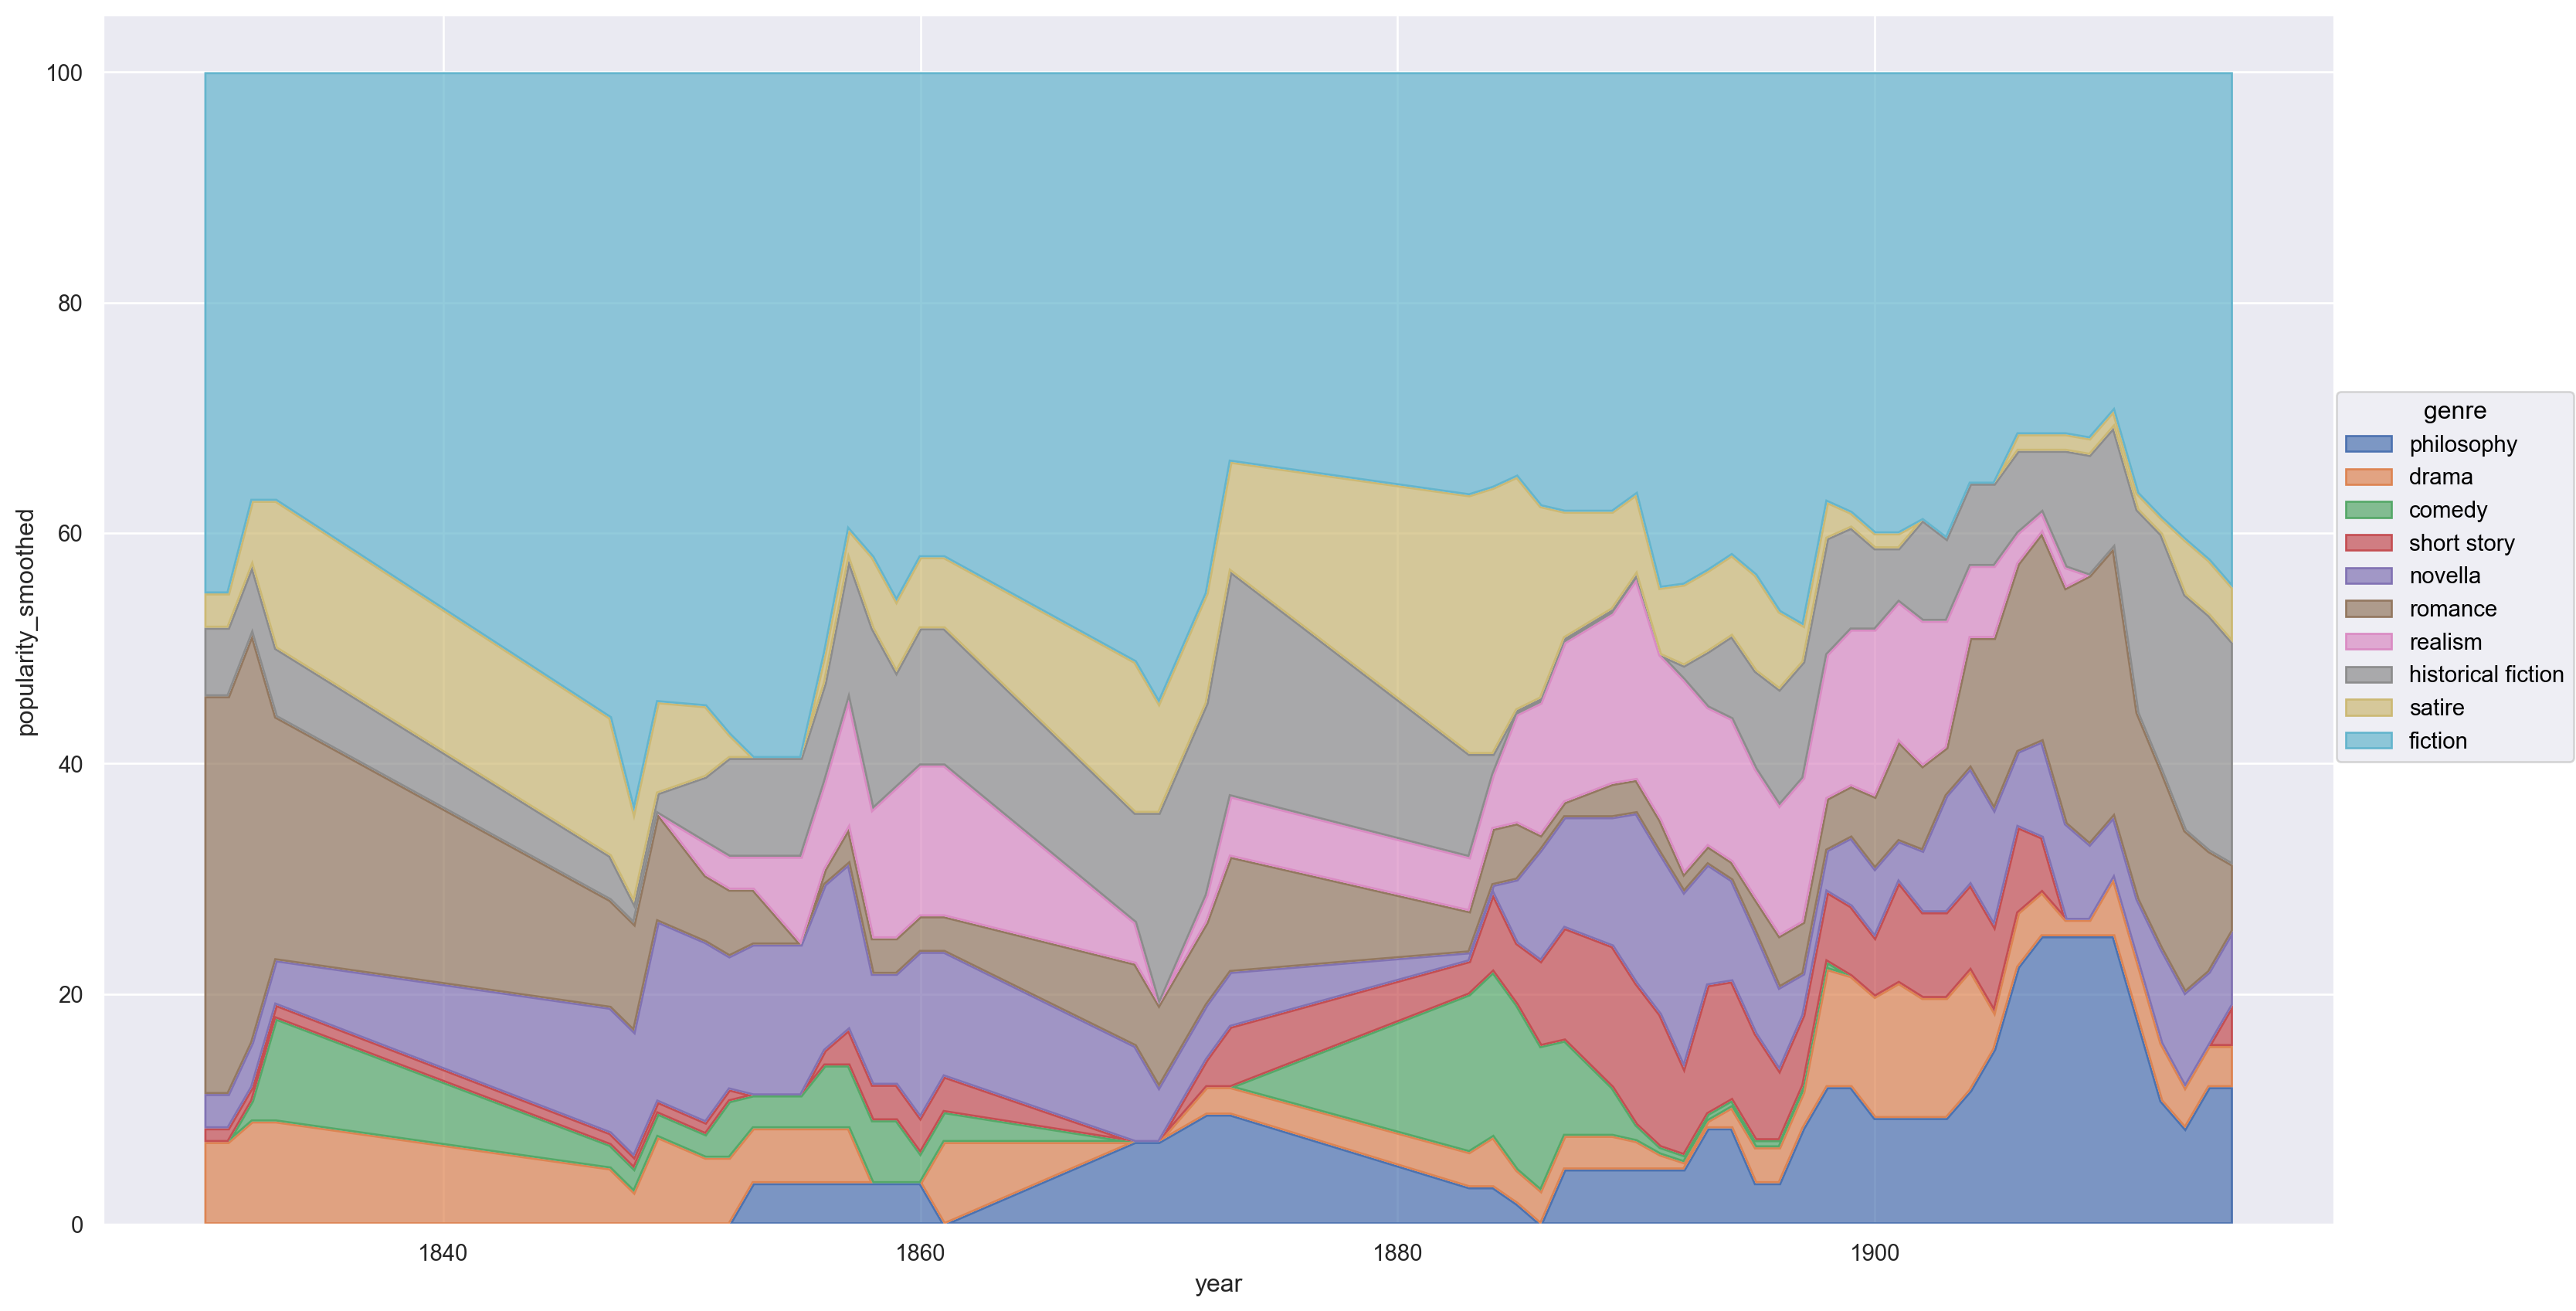

In [90]:
melted_percentage_filtered_genre_trends["popularity_smoothed"] = (
    melted_percentage_filtered_genre_trends.groupby("genre")["popularity"].transform(
        lambda x: x.rolling(window=7, center=True).mean()
    )
)

so.Plot(
    melted_percentage_filtered_genre_trends,
    "year",
    "popularity_smoothed",
    color="genre",
).add(so.Area(alpha=0.7), so.Stack()).layout(size=(16, 9)).save(
    "gemini2.png", bbox_inches="tight"
)

In [ ]:
# gemini_pro_long.generate_content(
#     "\"The play portrays the visit of an elderly professor and his glamorous, much younger second wife, Yelena, to the rural estate that supports their urban lifestyle. Two friends—Vanya, brother of the professor's late first wife, who has long managed the estate, and Astrov, the local doctor—both fall under Yelena's spell while bemoaning the ennui of their provincial existence. Sonya, the professor's daughter by his first wife, who has worked with Vanya to keep the estate going, suffers from her unrequited feelings for Astrov. Matters are brought to a crisis when the professor announces his intention to sell the estate, Vanya and Sonya's home, with a view to investing the proceeds to achieve a higher income for himself and his wife.\"\nRepeat each sentance with a catigorization after: horror short story humor social commentary satire fiction historical tragedy romance drama"
# ).candidates[0].content.parts[0].text

In [ ]:
# gemini_pro_long.generate_content(
#     "\"The play portrays the visit of an elderly professor and his glamorous, much younger second wife, Yelena, to the rural estate that supports their urban lifestyle. Two friends—Vanya, brother of the professor's late first wife, who has long managed the estate, and Astrov, the local doctor—both fall under Yelena's spell while bemoaning the ennui of their provincial existence. Sonya, the professor's daughter by his first wife, who has worked with Vanya to keep the estate going, suffers from her unrequited feelings for Astrov. Matters are brought to a crisis when the professor announces his intention to sell the estate, Vanya and Sonya's home, with a view to investing the proceeds to achieve a higher income for himself and his wife.\"\nRewrite the abstract like Uncle Vanya was a political commentary satire of Russia in 1870:"
# ).candidates[0].content.parts[0].text